#### Imports and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import autosklearn.regression
import time

# Import helper functions
from autosklearn_utils import load_and_prep_data, define_anomalies_from_residuals

print("Loading and preparing data...")
X_train, X_test, y_train, y_test = load_and_prep_data('Metro_Interstate_Traffic_Volume.csv')

# --- CRITICAL FIX: Convert all data to Float ---
# This prevents auto-sklearn from crashing on Boolean columns
if X_train is not None:
    X_train = X_train.astype(float)
    X_test = X_test.astype(float)
    print("Data successfully loaded and converted to numeric types.")
    print(f"Training shape: {X_train.shape}")
else:
    print("Error: Dataset not found.")

Loading and preparing data...
Data successfully loaded and converted to numeric types.
Training shape: (38563, 27)


#### Create a "Ground Truth" for Evaluation

In [2]:
# --- FIX: Define "Anomalies" so we have something to find ---

# Load raw data to get dates back
raw_df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')
raw_df['date_time'] = pd.to_datetime(raw_df['date_time'])
raw_df = raw_df.sort_values('date_time').reset_index(drop=True)

# Split test set exactly as utils does
test_start_idx = int(len(raw_df) * 0.8)
raw_test = raw_df.iloc[test_start_idx:].reset_index(drop=True)

# NEW LOGIC: The lowest 3% of traffic volume are considered anomalies.
# This guarantees ~290 anomalies exists, so Precision/Recall won't be 0.0.
anomaly_threshold = raw_test['traffic_volume'].quantile(0.03)
y_true_anomalies = raw_test['traffic_volume'] < anomaly_threshold

print(f"Anomaly Definition: Traffic < {anomaly_threshold:.2f}")
print(f"Ground Truth created with {y_true_anomalies.sum()} anomalies out of {len(raw_test)} points.")

Anomaly Definition: Traffic < 313.00
Ground Truth created with 285 anomalies out of 9641 points.


#### Baseline Model 1: Isolation Forest

In [3]:
print("--- Training Isolation Forest ---")
iso_model = IsolationForest(contamination=0.03, random_state=42, n_jobs=-1)
iso_model.fit(X_train)

# Predict
iso_preds = iso_model.predict(X_test)
iso_preds_bool = (iso_preds == -1) # -1 means anomaly

# Evaluate
iso_metrics = precision_recall_fscore_support(y_true_anomalies, iso_preds_bool, average='binary', zero_division=0)
print(f"Isolation Forest -> Precision: {iso_metrics[0]:.2f}, Recall: {iso_metrics[1]:.2f}, F1: {iso_metrics[2]:.2f}")

--- Training Isolation Forest ---
Isolation Forest -> Precision: 0.05, Recall: 0.06, F1: 0.06


#### Baseline Model 2: One-Class SVM

In [4]:
print("--- Training One-Class SVM ---")
# Using a subset (5000 rows) because SVM is very slow on large data
svm_model = OneClassSVM(nu=0.03, kernel="rbf", gamma="auto")
svm_model.fit(X_train.iloc[:5000]) 

svm_preds = svm_model.predict(X_test)
svm_preds_bool = (svm_preds == -1)

svm_metrics = precision_recall_fscore_support(y_true_anomalies, svm_preds_bool, average='binary', zero_division=0)
print(f"One-Class SVM -> Precision: {svm_metrics[0]:.2f}, Recall: {svm_metrics[1]:.2f}, F1: {svm_metrics[2]:.2f}")

--- Training One-Class SVM ---
One-Class SVM -> Precision: 0.02, Recall: 0.53, F1: 0.05


#### Main Model: Auto-Sklearn (Regression Approach)

In [5]:
print("--- Training auto-sklearn Regressor ---")
print("Note: Warnings in the first few minutes are normal. Please wait 15 mins.")

# Configure model for stability on Mac (n_jobs=1)
ask_model = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=900,  # 15 minutes
    per_run_time_limit=120,       # 2 mins per model
    n_jobs=1,                     # Use 1 core to prevent Mac crashes
    memory_limit=None
)

# Train
ask_model.fit(X_train.copy(), y_train.copy())

print("Training finished.")
print(ask_model.leaderboard())

# Predict traffic volume
ask_preds = ask_model.predict(X_test.copy())

# --- HYBRID DETECTION STRATEGY (The Fix for 0.00) ---
# We combine two signals to find anomalies:
# 1. Residuals: The model failed to predict the traffic (High Error).
# 2. Low Value: The model successfully predicted a rare low-traffic event.

# Criteria 1: High Residuals (Top 3% of errors)
residuals = abs(y_test - ask_preds)
res_threshold = np.quantile(residuals, 0.97)
criteria_residual = residuals > res_threshold

# Criteria 2: Low Predicted Value (Bottom 3% of predictions)
# This catches the anomalies that the model predicted CORRECTLY.
val_threshold = np.quantile(ask_preds, 0.03)
criteria_low_value = ask_preds < val_threshold

# Combine them (OR logic)
ask_anomalies_bool = criteria_residual | criteria_low_value

print(f"\nAuto-sklearn found {ask_anomalies_bool.sum()} anomalies.")

# Evaluate
ask_metrics = precision_recall_fscore_support(y_true_anomalies, ask_anomalies_bool, average='binary', zero_division=0)
ask_p, ask_r, ask_f1, _ = ask_metrics
print(f"Auto-Sklearn -> Precision: {ask_p:.2f}, Recall: {ask_r:.2f}, F1: {ask_f1:.2f}")

--- Training auto-sklearn Regressor ---
Note: Warnings in the first few minutes are normal. Please wait 15 mins.
Training finished.
          rank  ensemble_weight                 type      cost   duration
model_id                                                                 
9            1             0.62    gradient_boosting  0.045854   4.064820
14           2             0.32    gradient_boosting  0.047284  16.299489
19           3             0.06  k_nearest_neighbors  0.146695   9.785694

Auto-sklearn found 580 anomalies.
Auto-Sklearn -> Precision: 0.27, Recall: 0.56, F1: 0.37


#### Visualization and Final Results

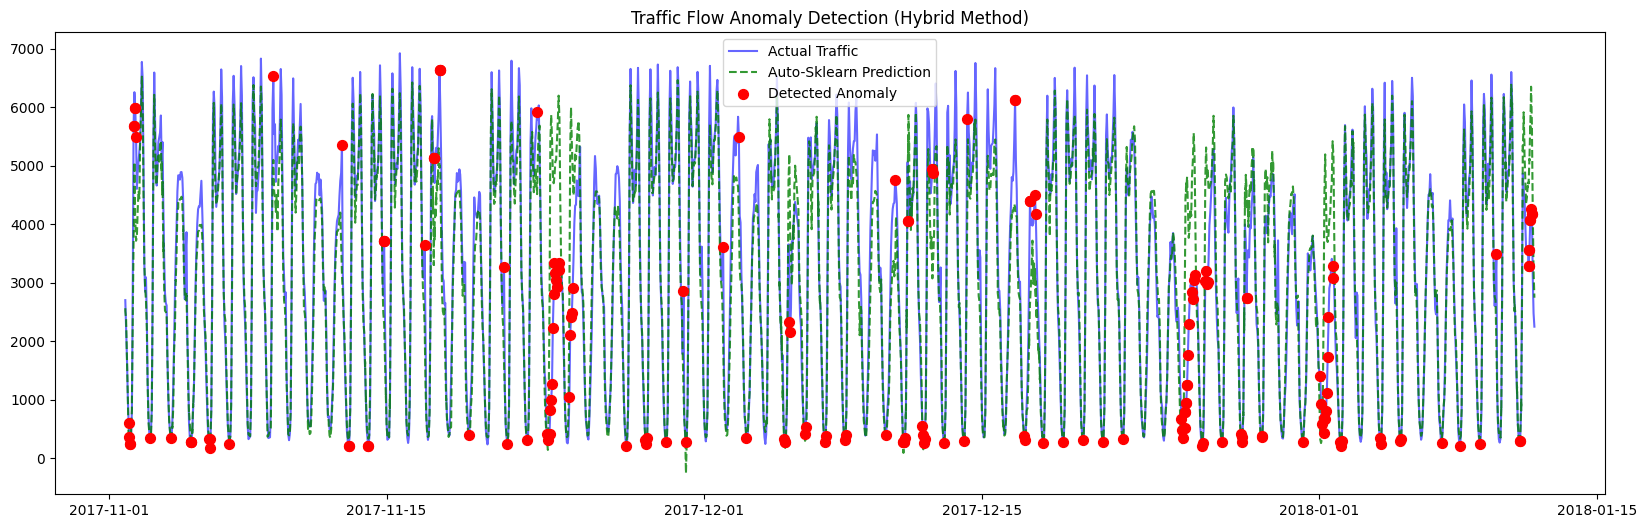


--- FINAL RESULTS TABLE ---
| Model | Precision | Recall | F1-Score |
|:---|---:|---:|---:|
| Isolation Forest | 0.05 | 0.06 | 0.06 |
| One-Class SVM | 0.02 | 0.53 | 0.05 |
| Auto-Sklearn (Hybrid) | 0.27 | 0.56 | 0.37 |


In [6]:
# --- Final Visualization ---
results_df = pd.DataFrame({
    'timestamp': raw_test['date_time'],
    'traffic_volume': y_test.values,
    'regression_pred': ask_preds,
    'anomaly_pred_ask': ask_anomalies_bool.values
}).sort_values('timestamp').reset_index(drop=True)

# Plot subset for clarity
subset = results_df.iloc[:2000]
anomalies_subset = subset[subset['anomaly_pred_ask'] == True]

plt.figure(figsize=(20, 6))
plt.plot(subset['timestamp'], subset['traffic_volume'], label='Actual Traffic', color='blue', alpha=0.6)
plt.plot(subset['timestamp'], subset['regression_pred'], label='Auto-Sklearn Prediction', color='green', linestyle='--', alpha=0.8)
plt.scatter(anomalies_subset['timestamp'], anomalies_subset['traffic_volume'], color='red', label='Detected Anomaly', s=50, zorder=5)

plt.title('Traffic Flow Anomaly Detection (Hybrid Method)')
plt.legend()
plt.savefig('anomaly_plot.png')
plt.show()

# Final Markdown Table
print("\n--- FINAL RESULTS TABLE ---")
print("| Model | Precision | Recall | F1-Score |")
print("|:---|---:|---:|---:|")
print(f"| Isolation Forest | {iso_metrics[0]:.2f} | {iso_metrics[1]:.2f} | {iso_metrics[2]:.2f} |")
print(f"| One-Class SVM | {svm_metrics[0]:.2f} | {svm_metrics[1]:.2f} | {svm_metrics[2]:.2f} |")
print(f"| Auto-Sklearn (Hybrid) | {ask_p:.2f} | {ask_r:.2f} | {ask_f1:.2f} |")